In [9]:
import os
import sys
import pandas as pd
import logging
import openrouteservice
import time


logging.basicConfig(level=os.environ.get("LOGLEVEL", "INFO"))
sys.path.append("../scripts")
from distance_proximity import proximity, travel_time

api_key = os.environ["ORS_KEY"]


# CALL_RANGE = range(0 + 200 * ITER, 200 + 200 * ITER, 1)
CALL_RANGE = range(12000, 15272, 1)


school_df = pd.read_csv("../data/raw/school.csv", encoding="cp1252")


In [17]:
# # Once off to create column for travel time to schoo
# scraped_df = pd.read_json(
#     "../data/raw/scrape_2022-09-02_04-12-25-567025.json", orient="records"
# )
# scraped_df['school_duration'] = 0
# scraped_df['school_distance'] = 0
# scraped_df.to_csv("../data/curated/scraped_with_school_tt.csv")


In [10]:
scraped_school_df = pd.read_csv("../data/curated/scraped_with_school_tt.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../data/curated/scraped_with_school_tt.csv'

In [48]:
start_time = time.time()
for i in CALL_RANGE:
    try:
        #-37.7751338, 144.7970672
        candidate_1, candidate_2 = proximity(
            scraped_school_df.iloc[i, -4],
            scraped_school_df.iloc[i, -3],
            school_df.Y.values.tolist(),
            school_df.X.values.tolist(),
        )

        #144.7970672, -37.7751338, 
        dis_1, dur_1 = travel_time(
            scraped_school_df.iloc[i, -3],
            scraped_school_df.iloc[i, -4],
            school_df.iloc[candidate_1]["X"],
            school_df.iloc[candidate_1]["Y"],
            api_key,
        )
        dis_2, dur_2 = travel_time(
            scraped_school_df.iloc[i, -3],
            scraped_school_df.iloc[i, -4],
            school_df.iloc[candidate_2]["X"],
            school_df.iloc[candidate_2]["Y"],
            api_key,
        )
        if dur_1 > dur_2:
            scraped_school_df.at[i, "school_duration"] = dur_2 / 60
            scraped_school_df.at[i, "school_distance"] = dis_2
        else:
            scraped_school_df.at[i, "school_duration"] = dur_1 / 60
            scraped_school_df.at[i, "school_distance"] = dis_1
        logging.info(f"Finished property index {i}")
    except Exception as e:
        logging.error(e)
        continue

end_time = time.time()
logging.info(f"Time taken, {(end_time - start_time)/60} mins")

scraped_school_df.to_csv("../data/curated/scraped_with_school_tt.csv")


INFO:root:Finished property index 12000
INFO:root:Finished property index 12001
INFO:root:Finished property index 12002
INFO:root:Finished property index 12003
INFO:root:Finished property index 12004
INFO:root:Finished property index 12005
INFO:root:Finished property index 12006
INFO:root:Finished property index 12007
INFO:root:Finished property index 12008
INFO:root:Finished property index 12009
/Users/matthewrush/virtualenv/lib/python3.10/site-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 1st time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/Users/matthewrush/virtualenv/lib/python3.10/site-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 2nd time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/Users/matthewrush/virtualenv/lib/python3.10/site-packages/openrouteservice/client.py:211: UserWarning: Ra

Downloaded Protobuf data 'Melbourne.osm.pbf' (31.09 MB) to:
'/var/folders/tj/r1w0q56s7rv8mhrmmgm8w4cr0000gn/T/pyrosm/Melbourne.osm.pbf'


/Users/matthewrush/virtualenv/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(


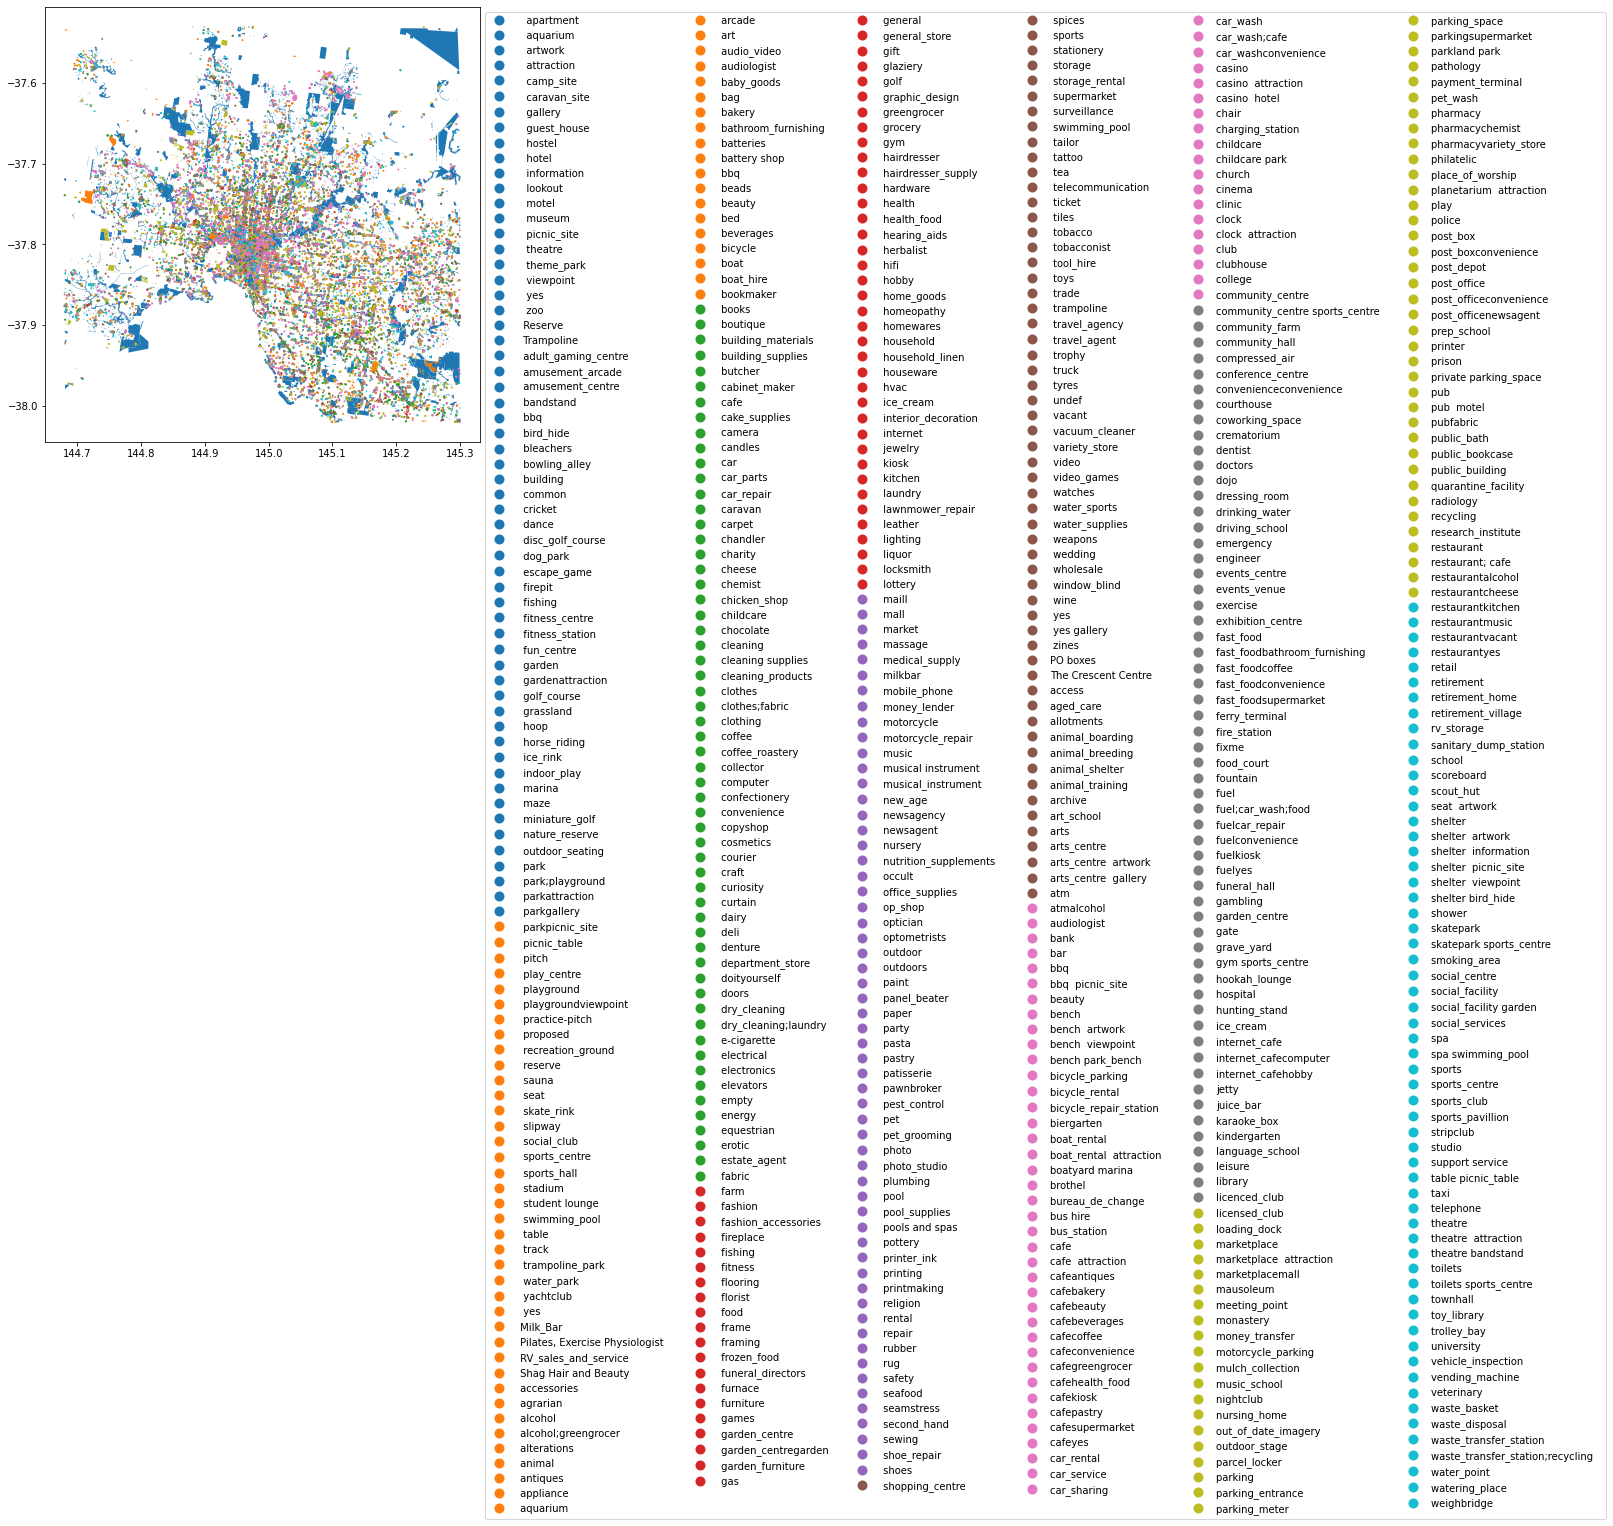

In [7]:
from pyrosm import OSM, get_data
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Get test data 
fp = get_data("melbourne")

# Initialize the reader
osm = OSM(fp)

# Read POIs with custom filter B
my_filter={"shop": True, "tourism": True, "amenity": True, "leisure": True}
pois = osm.get_pois(custom_filter=my_filter)

# Merge poi type information into a single column
pois["shop"] = pois["shop"].fillna(' ')
pois["amenity"] = pois["amenity"].fillna(' ')
pois["leisure"] = pois["leisure"].fillna(' ')
pois["tourism"] = pois["tourism"].fillna(' ')
pois["poi_type"] = pois["amenity"] + pois["shop"] + pois["leisure"] + pois["tourism"] 

# Plot
ax = pois.plot(column="poi_type", legend=True, markersize=1, figsize=(14,8), legend_kwds=dict(loc='upper left', ncol=6, bbox_to_anchor=(1, 1)))